In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from pytorch_model_summary import summary
from tsnecuda import TSNE
import pygama as pg

In [2]:
#check for GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


(79434, 3404)
(66200, 3404)
(13200, 3404)
(13200,)
(13200,)
(13200,)
(13200,)


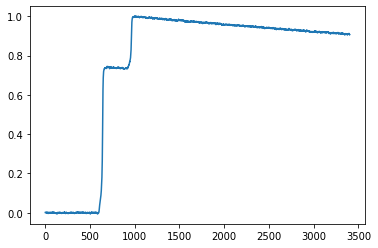

In [3]:
# .npy files extracted from file: /global/project/projectdirs/m2676/data/lngs/pgt/raw/geds/LPGTA_r0030_20200723T141228Z_calib_geds_raw.lh5
# have to process raw file using raw_to_dsp.py from pygama first, then save waveforms and other parameters into npy file

#load data print dimensions of data set
import matplotlib.pyplot as plt
import numpy as np

waveforms = np.load('g032_waveforms.npy')
psd_sum10 = np.load('g032_psd_sum10.npy')
bl_slope  = np.load('g032_bl_slope.npy')
tp_0 = np.load('g032_tp_0.npy')
tp_50 = np.load('g032_tp_50.npy')

train_data = waveforms[0:66200,:]
test_data = waveforms[66200:79400,:] #lose 34 observations for validation
test_psd10 = psd_sum10[66200:79400]
test_bl_slope = bl_slope[66200:79400]
test_tp_0= tp_0[66200:79400]
test_tp_50 = tp_50[66200:79400]

print(waveforms.shape)
print(train_data.shape)
print(test_data.shape)
print(test_psd10.shape)
print(test_bl_slope.shape)
print(test_tp_0.shape)
print(test_tp_0.shape)

plt.plot(np.arange(len(waveforms[374,:])), waveforms[374,:]) #anomalous sample wf 
plt.show()

In [4]:
#Convert data to tensors
train_data, test_data = map(torch.tensor, (train_data, test_data))

# batch size 
bs = 50 

#train data loader
train_ds = TensorDataset(train_data)
train_dl = DataLoader(train_ds, batch_size=bs) #removed batch shuffling here

#test data loader
valid_ds = TensorDataset(test_data)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [5]:
#Send data to GPU
def preprocess(x):
    return x.to(DEVICE)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl,preprocess)

In [6]:
#Define Convolutional Autoencoder

class waveform_cae_ralph(nn.Module):
    def __init__(self):
        super(waveform_cae_ralph, self).__init__()
        
        self.dropout = nn.Dropout(p=0.1)
        
        #Encoder
        self.conv1 = nn.Conv1d(1, 10, kernel_size=20, stride=1)
        self.conv2 = nn.Conv1d(10, 20, kernel_size=20, stride=1)
        self.batchnorm = nn.BatchNorm1d(10)
        self.maxpool = nn.MaxPool1d(5)
        self.fc1 = nn.Linear(2620, 980)
        self.fc2 = nn.Linear(980, 100)
        
        #Decoder
        self.deconv1 = nn.ConvTranspose1d(10,20,kernel_size=20,stride=1)
        self.deconv2 = nn.ConvTranspose1d(20,1,kernel_size=20,stride=1)
        self.fc3 = nn.Linear(100,980)
        self.fc4 = nn.Linear(980,5010)
        self.upsample1 = nn.Upsample(1500)
        self.upsample2 = nn.Upsample(3385)

    def forward(self, x):
        #Encoding part 
        x = x.view(bs,1,3404)
        x = torch.relu(self.conv1(x))
        x = self.maxpool(x)
        x = torch.relu(self.batchnorm(x))
        x = self.dropout(x)
        x = torch.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.dropout(x)
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        fvec = x
        
        #Decoding part 
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = x.view(bs,10,501)
        x = self.dropout(x)
        x = self.upsample1(x)
        x = torch.relu(self.deconv1(x))
        x = self.dropout(x)
        x = self.upsample2(x)
        x = torch.relu(self.deconv2(x))
        x = torch.flatten(x,1)
        return x, fvec

In [7]:
#Define Convolutional Autoencoder

class waveform_cae_aobo(nn.Module):
    def __init__(self):
        super(waveform_cae_aobo, self).__init__()
        
        self.dropout = nn.Dropout(p=0.5)
        self.lrelu = nn.LeakyReLU(0)
        
        #Encoder
        self.conv1 = nn.Conv1d(1, 10, kernel_size=20, stride=1)
        self.conv2 = nn.Conv1d(10, 10, kernel_size=20, stride=1)
        self.conv3 = nn.Conv1d(10, 10, kernel_size=20, stride=1)
        self.batchnorm1 = nn.BatchNorm1d(10)
        self.maxpool = nn.MaxPool1d(5)
        self.fc1 = nn.Linear(6390, 980)
        self.fc2 = nn.Linear(980, 100)
        
        #Decoder
        self.deconv1 = nn.ConvTranspose1d(10,10,kernel_size=20,stride=1)
        self.deconv2 = nn.ConvTranspose1d(10,10,kernel_size=20,stride=1)
        self.deconv3 = nn.ConvTranspose1d(10,1,kernel_size=20,stride=1)
        self.batchnorm2 = nn.BatchNorm1d(10)
        self.fc3 = nn.Linear(100,980)
        self.fc4 = nn.Linear(980,6390)
        self.upsample = nn.Upsample(3404)

    def forward(self, x):
        #Encoding part 
        x = x.view(bs,1,3404)
        x = self.lrelu(self.conv1(x))
        x = self.maxpool(x)
        x = self.batchnorm1(x)
        x = self.lrelu(self.conv2(x))
        x = self.lrelu(self.conv3(x))
        x = self.dropout(x)
        x = torch.flatten(x,1)
        x = self.lrelu(self.fc1(x))
        x = self.dropout(x)
        x = self.lrelu(self.fc2(x))
        fvec = x
        
        #Decoding part 
        x = self.lrelu(self.fc3(x))
        x = self.dropout(x)
        x = self.lrelu(self.fc4(x))
        x = self.dropout(x)
        x = x.view(bs,10,639)
        x = self.lrelu(self.deconv1(x))
        x = self.lrelu(self.deconv2(x))
        x = self.batchnorm2(x)
        x = self.lrelu(self.deconv3(x))
        x = self.upsample(x)
        x = torch.flatten(x,1)
        return x, fvec

In [8]:
#Summarize model, make sure dimensions match in between layers

model_ralph = waveform_cae_ralph()
model_aobo = waveform_cae_aobo()
print(summary(model_ralph,torch.zeros(bs,3404), show_hierarchical=True))
print(summary(model_aobo,torch.zeros(bs,3404),show_hierarchical=True))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv1d-1      [50, 10, 3385]             210             210
          MaxPool1d-2       [50, 10, 677]               0               0
        BatchNorm1d-3       [50, 10, 677]              20              20
            Dropout-4       [50, 10, 677]               0               0
             Conv1d-5       [50, 20, 658]           4,020           4,020
             Linear-6           [50, 980]       2,568,580       2,568,580
             Linear-7           [50, 100]          98,100          98,100
             Linear-8           [50, 980]          98,980          98,980
             Linear-9          [50, 5010]       4,914,810       4,914,810
          Upsample-10      [50, 10, 1500]               0               0
   ConvTranspose1d-11      [50, 20, 1519]           4,020           4,020
          Upsample-12      [50, 20, 3

In [9]:
#training function 
def train(model, num_epochs, batch_size, learning_rate, filename):
    torch.manual_seed(42)
    criterion = nn.MSELoss()# mean squared error loss
    criterion.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # <--

    epochs = []
    losses = []
    wfs = []
    recons = []
    
    model.train()
    for epoch in range(num_epochs):
        for data in train_dl:
            wf = data
            recon, _ = model(wf)
            loss = criterion(recon, wf)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            

            
            if epoch == (num_epochs-1):     #save waveforms for last epoch only 
                wfs.append(wf.cpu().detach())
                recons.append(recon.cpu().detach())
            else:
                continue

        epochs.append(epoch)
        losses.append(loss)
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        
    torch.save(model.state_dict(), filename)
        
    return epochs, losses, wfs, recons

#validating function 
def validate(model, num_epochs):
    torch.manual_seed(42)
    criterion = nn.MSELoss()# mean squared error loss
    criterion.to(DEVICE)
    
    fvecs = []
    model.eval()
    for epoch in range(num_epochs):
        with torch.no_grad():
            for data in valid_dl:
                wf = data
                recon, fvec = model(wf)
                loss = criterion(recon, wf)
                if epoch == (num_epochs-1):     #save fvecs for last epoch only 
                    fvecs.append(fvec.cpu())
                else:
                    continue
                
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
              
    return fvecs

                

In [10]:
#train model 
import time

max_epochs = 30
lr = 1e-4

model_aobo.to(DEVICE)
start_time = time.time()
epochs, losses, wfs, recons = train(model_aobo, max_epochs, bs, lr,'aobo_mse_lr0001_lrelu0_30epochs.pt')
print("--- %s seconds ---" % (time.time() - start_time))

Epoch:1, Loss:0.0050
Epoch:2, Loss:0.0028
Epoch:3, Loss:0.0026
Epoch:4, Loss:0.0016
Epoch:5, Loss:0.0012
Epoch:6, Loss:0.0008
Epoch:7, Loss:0.0010
Epoch:8, Loss:0.0007
Epoch:9, Loss:0.0007
Epoch:10, Loss:0.0009
Epoch:11, Loss:0.0007
Epoch:12, Loss:0.0005
Epoch:13, Loss:0.0005
Epoch:14, Loss:0.0005
Epoch:15, Loss:0.0006
Epoch:16, Loss:0.0006
Epoch:17, Loss:0.0005
Epoch:18, Loss:0.0006
Epoch:19, Loss:0.0005
Epoch:20, Loss:0.0004
Epoch:21, Loss:0.0005
Epoch:22, Loss:0.0004
Epoch:23, Loss:0.0005
Epoch:24, Loss:0.0004
Epoch:25, Loss:0.0005
Epoch:26, Loss:0.0005
Epoch:27, Loss:0.0005
Epoch:28, Loss:0.0006
Epoch:29, Loss:0.0004
Epoch:30, Loss:0.0005
--- 233.94917106628418 seconds ---


In [11]:
#concatenate training model outputs
train_wfs = np.concatenate(wfs, axis=0)
train_recons = np.concatenate(recons, axis=0)
print(train_wfs.shape)
print(train_recons.shape)

(66200, 3404)
(66200, 3404)


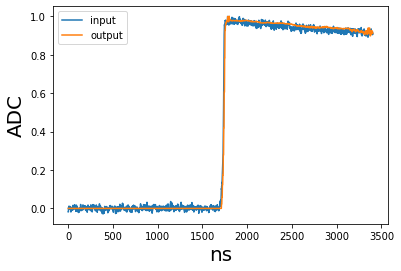

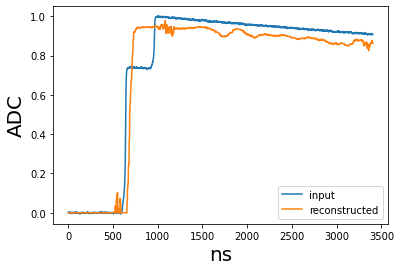

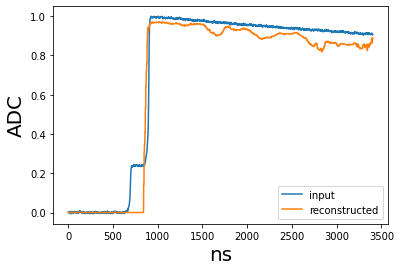

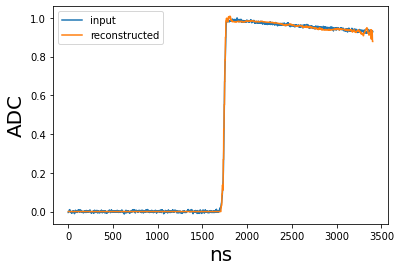

In [12]:
#plot input and corresponding reconstructed waveform

#plt.suptitle("Sample input and reconstructed waveform", fontsize=18)
plt.plot(np.arange(len(train_wfs[1000,:])), train_wfs[1000,:], label='input')
plt.plot(np.arange(len(train_recons[1000,:])), train_recons[1000,:], label='output')
plt.ylabel('ADC', fontsize=20)
plt.xlabel("ns", fontsize=20)
plt.legend()
plt.show()

plt.plot(np.arange(len(train_wfs[374,:])), train_wfs[374,:], label='input')
plt.plot(np.arange(len(train_recons[374,:])), train_recons[374,:], label='reconstructed')
plt.ylabel('ADC', fontsize=20)
plt.xlabel("ns", fontsize=20)
plt.legend()
plt.show()

plt.plot(np.arange(len(train_wfs[9097,:])), train_wfs[9097,:], label='input')
plt.plot(np.arange(len(train_recons[9097,:])), train_recons[9097,:], label='reconstructed')
plt.ylabel('ADC', fontsize=20)
plt.xlabel("ns", fontsize=20)
plt.legend()
plt.show()

plt.plot(np.arange(len(train_wfs[30000,:])), train_wfs[30000,:], label='input')
plt.plot(np.arange(len(train_recons[30000,:])), train_recons[30000,:], label='reconstructed')
plt.ylabel('ADC', fontsize=20)
plt.xlabel("ns", fontsize=20)
plt.legend()
plt.show()


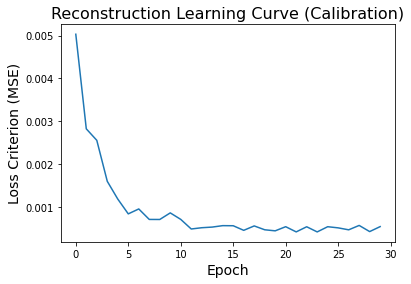

In [13]:
#plot loss function of CAE
epochs = np.asarray(epochs)
losses = np.asarray(losses)
plt.plot(epochs,losses)
plt.title('Reconstruction Learning Curve (Calibration)', fontsize=16)
plt.ylabel('Loss Criterion (MSE)', fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.show()

In [14]:
#test model, obtain feature vectors to feed into TSNE

#import time
#model_aobo.load_state_dict(torch.load('aobo_mse_lr0001_lrelu0_30epochs.pt'))
#model_aobo.to(DEVICE)

max_epochs = 20
start_time = time.time()
fvecs = validate(model_aobo,max_epochs)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch:1, Loss:0.0018
Epoch:2, Loss:0.0018
Epoch:3, Loss:0.0018
Epoch:4, Loss:0.0018
Epoch:5, Loss:0.0018
Epoch:6, Loss:0.0018
Epoch:7, Loss:0.0018
Epoch:8, Loss:0.0018
Epoch:9, Loss:0.0018
Epoch:10, Loss:0.0018
Epoch:11, Loss:0.0018
Epoch:12, Loss:0.0018
Epoch:13, Loss:0.0018
Epoch:14, Loss:0.0018
Epoch:15, Loss:0.0018
Epoch:16, Loss:0.0018
Epoch:17, Loss:0.0018
Epoch:18, Loss:0.0018
Epoch:19, Loss:0.0018
Epoch:20, Loss:0.0018
--- 8.40584945678711 seconds ---


In [15]:
#concatenate results from validation step
test_fvecs = np.concatenate(fvecs ,axis=0)
np.shape(test_fvecs)

(13200, 100)

In [16]:
#feed fvecs into TSNE

start_time = time.time()
test_embedded = TSNE(verbose=0, n_components=2, learning_rate=200).fit_transform(test_fvecs)
print("--- %s seconds ---" % (time.time() - start_time))
print(test_embedded.shape)

--- 3.806947946548462 seconds ---
(13200, 2)


In [18]:
import matplotlib
from matplotlib.lines import Line2D
matplotlib.use('Agg')

#Define plotting functions 
def plot_all_clusters(embedded_fvecs, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(embedded_fvecs[:, 0], embedded_fvecs[:, 1], 'b.', markersize=1)
    fig.suptitle("t-SNE Classification of Waveforms", fontsize=18)
    fig.savefig(filename)
    
def plot_all_clusters_psd(embedded_fvecs, tags, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(0,len(tags)):
        if tags[i] >= 0.65e6:
            ax.plot(embedded_fvecs[i, 0], embedded_fvecs[i, 1], 'r.', markersize=10)
        else:
            ax.plot(embedded_fvecs[i, 0], embedded_fvecs[i, 1], 'b.', markersize=1)
            
    fig.suptitle("t-SNE with PSD Tags", fontsize=18)
    legend_elements = [Line2D([0], [0], marker='.', color='w', label='low psd_sum10', markerfacecolor='b', markersize=15),
                       Line2D([0], [0], marker='.', color='w', label='high psd_sum10', markerfacecolor='r', markersize=15)]
    ax.legend(handles=legend_elements, fancybox=True, loc='upper right')
    fig.savefig(filename)
    

def plot_all_clusters_bl_slope(embedded_fvecs, tags, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(0,len(tags)):
        if tags[i] >= 0.1: 
            ax.plot(embedded_fvecs[i, 0], embedded_fvecs[i, 1], 'r.', markersize=10)
        elif tags[i] < -0.1:
            ax.plot(embedded_fvecs[i, 0], embedded_fvecs[i, 1], 'r.', markersize=10)
        else:
            ax.plot(embedded_fvecs[i, 0], embedded_fvecs[i, 1], 'b.', markersize=1)
            
    fig.suptitle("t-SNE with Baseline Slope Tags", fontsize=18)
    legend_elements = [Line2D([0], [0], marker='.', color='w', label='central bl_slope', markerfacecolor='b', markersize=15),
                       Line2D([0], [0], marker='.', color='w', label='outlier bl_slope', markerfacecolor='r', markersize=15)]
    ax.legend(handles=legend_elements, fancybox=True, loc='upper right')
    fig.savefig(filename)
    
def plot_2Dhist(embedded_fvecs, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    h = ax.hist2d(embedded_fvecs[:, 0], embedded_fvecs[:, 1], bins=50, density=True, cmap='hot')
    fig.colorbar(h[3], ax=ax)
    fig.suptitle("Density Plot of t-SNE Results", fontsize=18)
    fig.savefig(filename)


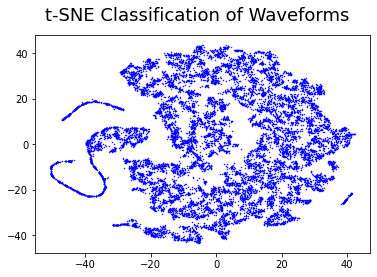

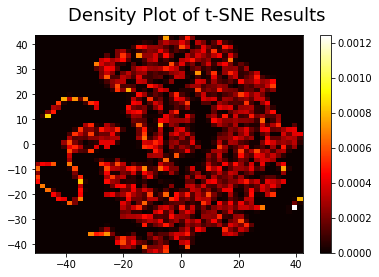

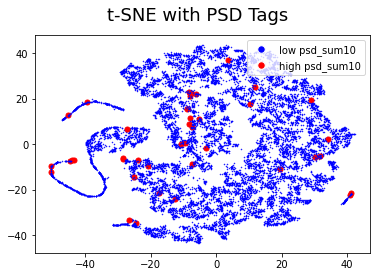

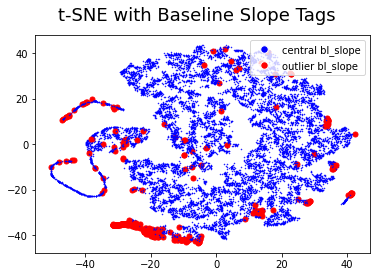

In [19]:
#Plot TSNE performance for various digits 

plot_all_clusters(test_embedded, "tsne_aobo_mse_lr0001_lrelu0")
plot_2Dhist(test_embedded, "2Dhist_aobo_mse_lr0001_lrelu0")
plot_all_clusters_psd(test_embedded, test_psd10, "tsne_aobo_mse_lr0001_lrelu0_psd")
plot_all_clusters_bl_slope(test_embedded, test_bl_slope, "tsne_aobo_mse_lr0001_lrelu0_bl_slope")
    